In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/fake-news-detection'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news-detection/true.csv
/kaggle/input/fake-news-detection/fake.csv


In [2]:
!pip uninstall -qqy jupyterlab kfp  # Remove unused conflicting packages
!pip install -U -q "google-genai==1.7.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 4.7 MB/s eta 0:00:00


In [3]:
from google import genai
from google.genai import types

genai.__version__

'1.7.0'

In [4]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

client = genai.Client(api_key=GOOGLE_API_KEY)

In [5]:
news_file_path = '/kaggle/input/fake-news-detection/true.csv'

# Load the dataset
news_file = pd.read_csv(news_file_path)

# Display the first few rows of the dataset
news_file.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [6]:
news_file.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [7]:
news_file['subject'].value_counts()

subject
politicsNews    11272
worldnews       10145
Name: count, dtype: int64

In [ ]:

import re

# Apply functions to remove names, emails, and extraneous words from data points in newsgroups.data
news_file = [re.sub(r"[\w\.-]+@[\w\.-]+", "", d) for d in news_file]

news_file = [re.sub(r"\S+@\S+", "", d) for d in news_file]  

news_file = [d.replace("From: ", "") for d in news_file]

news_file = [d.replace("\nSubject: ", "") for d in news_file] 

news_file = [d[0:5000] if len(d) > 5000 else d for d in news_file]
   

In [9]:
type(news_file)

pandas.core.frame.DataFrame

In [10]:
SAMPLE_SIZE = 600
df_train = (
    news_file.groupby("subject", as_index=False)
    .apply(lambda x: x.sample(SAMPLE_SIZE))
    .reset_index(drop=True)
)

df_train

<ipython-input-10-0370748d3b24>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(SAMPLE_SIZE))


,title,text,subject,date
0,Gingrich doesn't rule out Trump VP role,WASHINGTON (Reuters) - Republican veteran Newt...,politicsNews,"May 12, 2016"
1,"Bannon, Priebus top candidates for White House...",WASHINGTON (Reuters) - Donald Trump’s campaign...,politicsNews,"November 10, 2016"
2,Trump's call for probe of voter fraud sparks b...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"January 25, 2017"
3,Trump signs executive order to modernize U.S. ...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"May 1, 2017"
4,U.N. chief says no communication with North Ko...,UNITED NATIONS (Reuters) - United Nations Secr...,politicsNews,"April 28, 2017"
...,...,...,...,...
1195,Trump greets Japanese emperor with a handshake...,TOKYO (Reuters) - U.S. President Donald Trump ...,worldnews,"November 6, 2017"
1196,Buildings evacuated in Moscow after bomb threa...,MOSCOW (Reuters) - Russian authorities evacuat...,worldnews,"September 13, 2017"
1197,Belgian police commissioner nominated to lead ...,BRUSSELS (Reuters) - Belgian police commission...,worldnews,"December 6, 2017"
1198,Vietnam police arrest ex-politburo member over...,HANOI (Reuters) - Vietnamese police on Friday ...,worldnews,"December 8, 2017"


In [11]:
df_train["subject"].value_counts()


subject
politicsNews    600
worldnews       600
Name: count, dtype: int64

In [12]:
# Merge Title and Text (using a space separator)
df_train['Text'] = df_train['title'] + " : " + df_train['text']

# Show the merged DataFrame
print(df_train.head())

                                               title  \
0            Gingrich doesn't rule out Trump VP role   
1  Bannon, Priebus top candidates for White House...   
2  Trump's call for probe of voter fraud sparks b...   
3  Trump signs executive order to modernize U.S. ...   
4  U.N. chief says no communication with North Ko...   

                                                text       subject  \
0  WASHINGTON (Reuters) - Republican veteran Newt...  politicsNews   
1  WASHINGTON (Reuters) - Donald Trump’s campaign...  politicsNews   
2  WASHINGTON (Reuters) - President Donald Trump ...  politicsNews   
3  WASHINGTON (Reuters) - President Donald Trump ...  politicsNews   
4  UNITED NATIONS (Reuters) - United Nations Secr...  politicsNews   

                 date                                               Text  
0       May 12, 2016   Gingrich doesn't rule out Trump VP role : WASH...  
1  November 10, 2016   Bannon, Priebus top candidates for White House...  
2   January 25, 2

In [13]:
from tqdm.auto import tqdm
from google.genai import types

tqdm.pandas()

from google.api_core import retry
import numpy as np
import math


def make_embed_text_fn(model):

    @retry.Retry(timeout=300.0)
    def embed_fn(texts: list[str]) -> list[list[float]]:
        # Set the task_type to CLUSTERING and embed the batch of texts
        embeddings = client.models.embed_content(
            model=model,
            contents=texts,
            config=types.EmbedContentConfig(task_type="CLUSTERING"),
        ).embeddings
        return np.array([embedding.values for embedding in embeddings])

    return embed_fn


def create_embeddings(df):
    MODEL_ID = "text-embedding-004" # @param ["embedding-001","text-embedding-004"] {allow-input: true}
    model = f"models/{MODEL_ID}"
    embed_fn = make_embed_text_fn(model)

    batch_size = 100  # at most 100 requests can be in one batch
    all_embeddings = []

    # Loop over the texts in chunks of batch_size
    for i in tqdm(range(0, len(df), batch_size)):
        batch = df["Text"].iloc[i : i + batch_size].tolist()
        embeddings = embed_fn(batch)
        all_embeddings.extend(embeddings)

    df["Embeddings"] = all_embeddings
    return df


df_train = create_embeddings(df_train)

  0%|          | 0/12 [00:00<?, ?it/s]

In [14]:
len(df_train["Embeddings"][0])

768

In [15]:
# Convert df_train['Embeddings'] Pandas series to a np.array of float32
X = np.array(df_train["Embeddings"].to_list(), dtype=np.float32)
X.shape


(1200, 768)

In [16]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=0, n_iter=1000)
tsne_results = tsne.fit_transform(X)

In [17]:
df_tsne = pd.DataFrame(tsne_results, columns=["TSNE1", "TSNE2"])
df_tsne["subject"] = df_train[
    "subject"
]  # Add labels column from df_train to df_tsne
df_tsne
     

,TSNE1,TSNE2,subject
0,-26.454325,8.615683,politicsNews
1,-28.856974,-2.157665,politicsNews
2,-31.888865,8.105532,politicsNews
3,-14.905857,-11.242146,politicsNews
4,9.306299,-29.200882,politicsNews
...,...,...,...
1195,10.822296,-2.027363,worldnews
1196,47.697922,-8.915758,worldnews
1197,24.218794,30.969280,worldnews
1198,16.937429,6.620985,worldnews


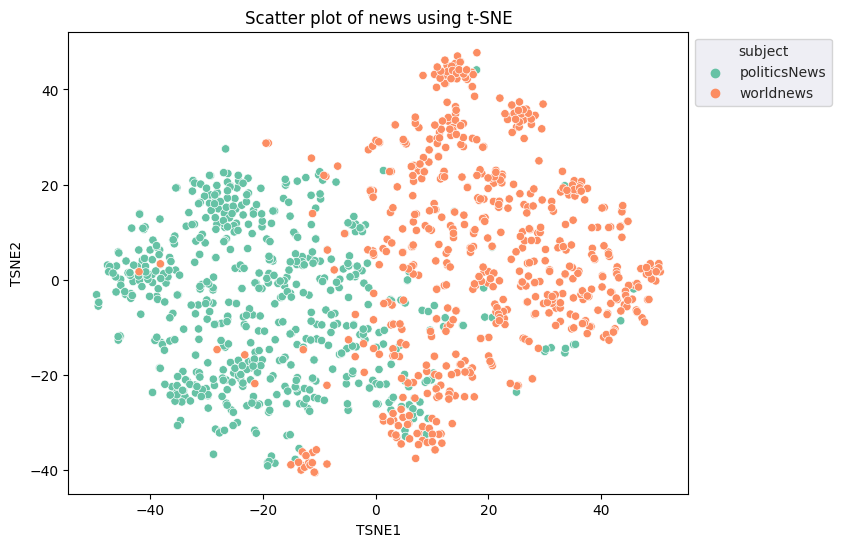

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 6))  # Set figsize
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x="TSNE1", y="TSNE2", hue="subject", palette="Set2")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Scatter plot of news using t-SNE")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2");

plt.show()

In [19]:
def get_centroids(df_tsne):
    # Get the centroid of each cluster
    centroids = df_tsne.groupby("subject").mean()
    return centroids


centroids = get_centroids(df_tsne)
centroids

,TSNE1,TSNE2
subject,,
politicsNews,-19.365643,-5.854596
worldnews,18.746288,5.234915


In [20]:
def get_embedding_centroids(df):
    emb_centroids = dict()
    grouped = df.groupby("subject")
    for c in grouped.groups:
        sub_df = grouped.get_group(c)
        # Get the centroid value of dimension 768
        emb_centroids[c] = np.mean(sub_df["Embeddings"], axis=0)

    return emb_centroids

In [21]:
emb_c = get_embedding_centroids(df_train)

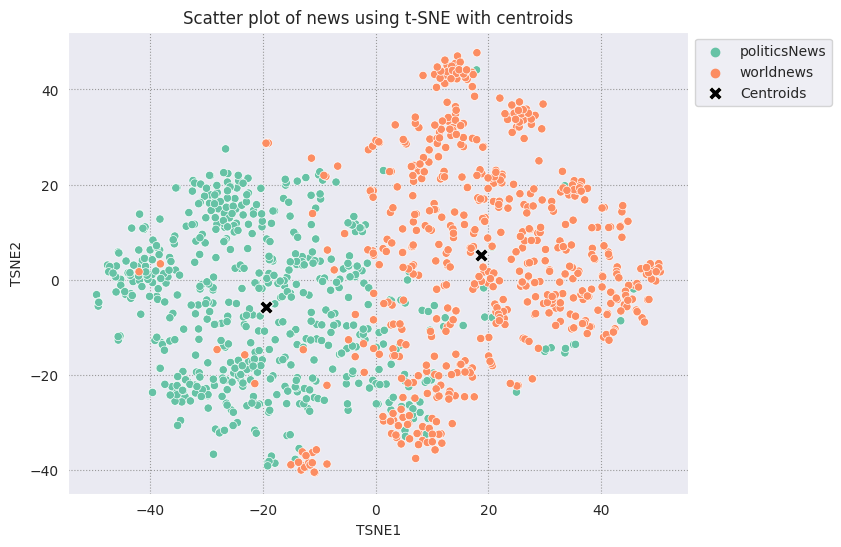

In [22]:
# Plot the centroids against the cluster
fig, ax = plt.subplots(figsize=(8, 6))  # Set figsize
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x="TSNE1", y="TSNE2", hue="subject", palette="Set2")
sns.scatterplot(
    data=centroids,
    x="TSNE1",
    y="TSNE2",
    color="black",
    marker="X",
    s=100,
    label="Centroids",
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Scatter plot of news using t-SNE with centroids")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2");

In [23]:
def calculate_euclidean_distance(p1, p2):
    return np.sqrt(np.sum(np.square(p1 - p2)))

In [24]:
def detect_outlier(df, emb_centroids, radius):
    for idx, row in df.iterrows():
        class_name = row["subject"]  # Get class name of row
        # Compare centroid distances
        dist = calculate_euclidean_distance(
            row["Embeddings"], emb_centroids[class_name]
        )
        df.at[idx, "Outlier"] = dist > radius

    return len(df[df["Outlier"] == True])

In [25]:
range_ = np.arange(0.3, 0.75, 0.02).round(decimals=2).tolist()
num_outliers = []
# for i in range_:
#     num_outliers.append(detect_outlier(df_train, emb_c, i))

for r in range_:
    df_train["Outlier"] = False  # Reset or initialize the column before each run
    count = detect_outlier(df_train, emb_c, r)
    num_outliers.append(count)

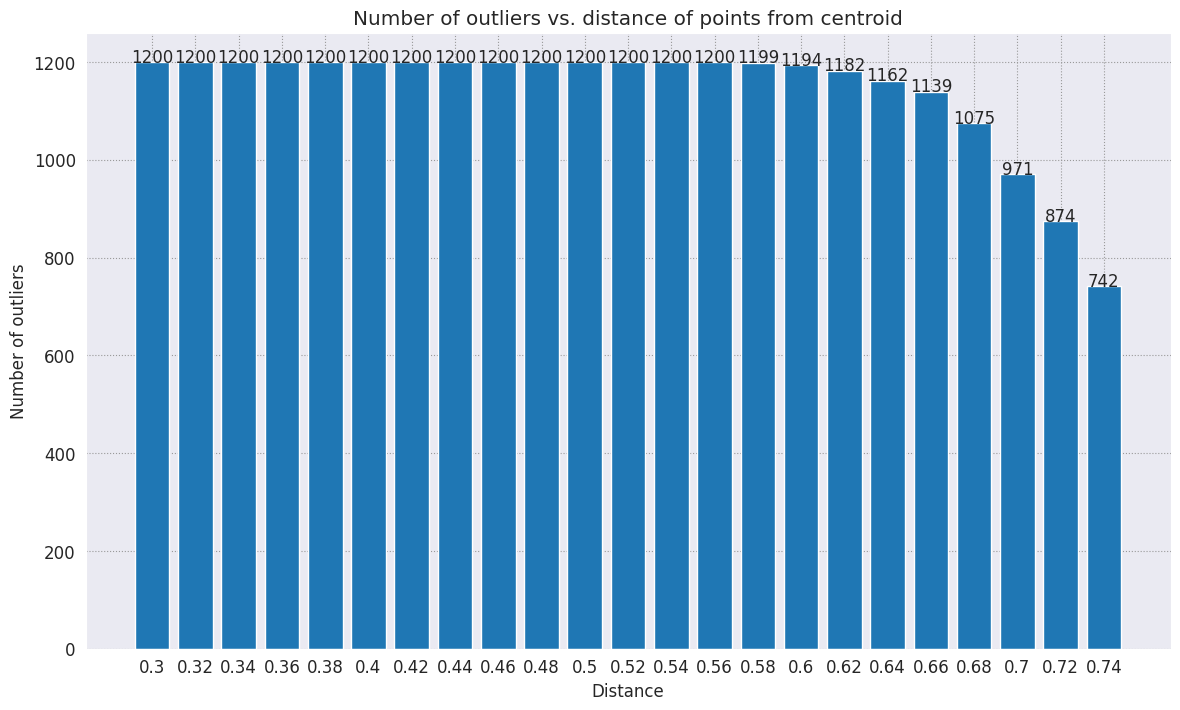

In [26]:
# Plot range_ and num_outliers
fig = plt.figure(figsize=(14, 8))
plt.rcParams.update({"font.size": 12})
plt.bar(list(map(str, range_)), num_outliers)
plt.title("Number of outliers vs. distance of points from centroid")
plt.xlabel("Distance")
plt.ylabel("Number of outliers")
for i in range(len(range_)):
    plt.text(i, num_outliers[i], num_outliers[i], ha="center")

plt.show()

In [27]:
# View the points that are outliers
RADIUS = 0.7
detect_outlier(df_train, emb_c, RADIUS)
df_outliers = df_train[df_train["Outlier"] == True]
df_outliers.head()

,title,text,subject,date,Text,Embeddings,Outlier
0,Gingrich doesn't rule out Trump VP role,WASHINGTON (Reuters) - Republican veteran Newt...,politicsNews,"May 12, 2016",Gingrich doesn't rule out Trump VP role : WASH...,"[0.049151123, -0.04354915, -0.04927078, 0.0298...",True
1,"Bannon, Priebus top candidates for White House...",WASHINGTON (Reuters) - Donald Trump’s campaign...,politicsNews,"November 10, 2016","Bannon, Priebus top candidates for White House...","[0.0249785, -0.082352206, -0.1085432, -0.02581...",True
4,U.N. chief says no communication with North Ko...,UNITED NATIONS (Reuters) - United Nations Secr...,politicsNews,"April 28, 2017",U.N. chief says no communication with North Ko...,"[0.05562334, -0.0111160595, -0.0031648295, 0.0...",True
6,U.S. Supreme Court rejects Texas appeal over v...,WASHINGTON (Reuters) - The U.S. Supreme Court ...,politicsNews,"January 23, 2017",U.S. Supreme Court rejects Texas appeal over v...,"[0.07699104, -0.02997885, 0.026297512, -0.0393...",True
8,Michigan governor names panel to fix Flint's c...,(Reuters) - Michigan Governor Rick Snyder on W...,politicsNews,"January 27, 2016",Michigan governor names panel to fix Flint's c...,"[0.06380617, 0.008656606, -0.035066765, 0.0122...",True


In [28]:
outliers_projected = df_tsne.loc[df_outliers["Outlier"].index]

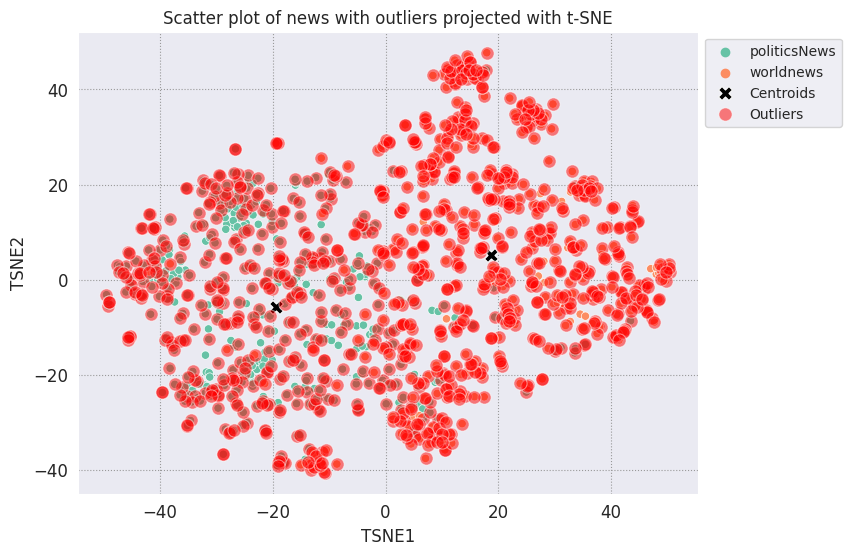

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))  # Set figsize
plt.rcParams.update({"font.size": 10})
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x="TSNE1", y="TSNE2", hue="subject", palette="Set2")
sns.scatterplot(
    data=centroids,
    x="TSNE1",
    y="TSNE2",
    color="black",
    marker="X",
    s=100,
    label="Centroids",
)
# Draw a red circle around the outliers
sns.scatterplot(
    data=outliers_projected,
    x="TSNE1",
    y="TSNE2",
    color="red",
    marker="o",
    alpha=0.5,
    s=90,
    label="Outliers",
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Scatter plot of news with outliers projected with t-SNE")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2");

In [30]:
world_news_outliers = df_outliers[df_outliers["subject"] == "worldnews"]
print(world_news_outliers["Text"].iloc[0])

Danish submarine owner has not said how journalist died: police : COPENHAGEN (Reuters) - A Danish inventor accused of murdering Swedish journalist Kim Wall on board his submarine did not say she died from carbon monoxide poisoning, police said on Wednesday, correcting an earlier statement. On Monday Danish police said Peter Madsen had told them in an Oct. 14 interrogation that Wall, 30, had died from carbon monoxide poisoning inside the submarine, while he was on the deck of the vessel. Reacting to comments by Madsen s defense lawyer, the police said on Wednesday he had not specifically said how Wall died but had mentioned the possibility of such a cause of death. Madsen is facing charges of murder, mutilating Wall s body and sexual assault without intercourse, based on 14 interior and exterior stab wounds found on her body. He denies killing Wall but has admitted to dismembering her body and dumping the parts in the sea, police have said. Wall, who was researching a story on Madsen, w

In [31]:

politics_news_outliers = df_outliers[df_outliers["subject"] == "politicsNews"]
print(politics_news_outliers["Text"].iloc[0])

Gingrich doesn't rule out Trump VP role : WASHINGTON (Reuters) - Republican veteran Newt Gingrich did not rule out on Wednesday the possibility that he could be persuaded to serve as presumptive nominee Donald Trump’s vice presidential running mate, but said Trump has plenty of other talent to consider. “I would certainly talk about it,” Gingrich told Fox News Channel’s Sean Hannity. “I wouldn’t turn it down automatically.” Gingrich has been a persistent subject of speculation as a possible Trump running mate. He is a former speaker of the House of Representatives and, as such, meets one of Trump’s main requirements for the job - that his No. 2 be someone who could help steer legislation through Congress. Gingrich ran for the Republican presidential nomination in 2012 and lost to the eventual nominee, Mitt Romney. He has been serving as an informal adviser to Trump, who has said he has narrowed his list of potential picks to five or six. Gingrich said in the Fox interview that former T